In [2]:
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

In [3]:
def Get_values_without_error(im,XX,YY):
    """ retouren une image de la taille de XX et YY 
     qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
     pas """
    sh=XX.shape
    defaultval=0;
    if len(im.shape)>2: #color image !
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp
    
    return imout 

def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
    """
   %
%Effectue la transformation geometrique d'une image par
%une rotation + homothetie 
%
% x' = alpha*cos(theta)*(x-x0) - alpha*sin(theta)*(y-y0) + x0
% y' = alpha*sin(theta)*(x-x0) + alpha*cos(theta)*(y-y0) + y0 
%
% theta : angle de rotation en degres
% alpha : facteur d'homothetie (defaut=1)
% x0, y0 : centre de la rotation (defaut=centre de l'image)
% ech : plus proche voisin (defaut=0) ou bilineaire (1)
% clip : format de l'image originale (defaut=True), image complete (False)
% 

    """ 
    dy=im.shape[0]
    dx=im.shape[1]
    
    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        #ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())
        
    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1)) 
    
    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))
    
    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # plus proche voisin
        out=Get_values_without_error(im,Xout,Yout)
    else:  #bilineaire 
        assert ech == 1 , "Vous avez choisi un echantillonnage inconnu"
        Y0=np.floor(Yout-0.5)+0.5 # on va au entier+0.5 inferieur
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1 #points entiers
        PoidsY[Y0==Y1]=1 #points entiers
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out

def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,mask):
    """ renvoie la convolution de l'image avec le mask. Le calcul se fait en 
utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
les images en niveau de gris.
"""
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def median_filter(im,typ=1,r=1,xy=None):
    """ renvoie le median de l'image im.
    si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    si typ==2 : disque de rayon r
    si typ==3 alors xy est un couple de liste de x et liste de y
         ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois. 
         """
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negatif
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positif
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    #print (lx,ly)
    #print(ttx,tty)
    #print(im[deby+ly[k]:tty+ly[k]+deby,debx+lx[k]:debx+ttx+lx[k]].reshape(-1).shape)
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def filtre_inverse(im,mask):
    """ renvoie l'inverse de mask applique a im.
    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)/fft2(mm))
    
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

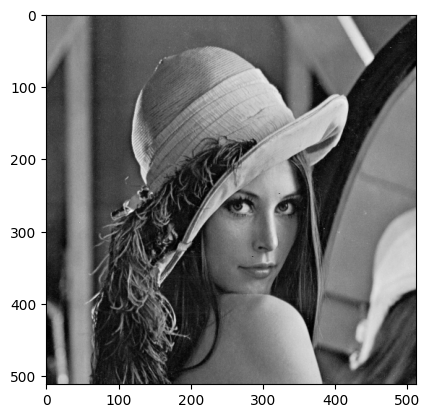

In [17]:
im=skio.imread('images/lena.tif')
plt.imshow(im,cmap='gray')

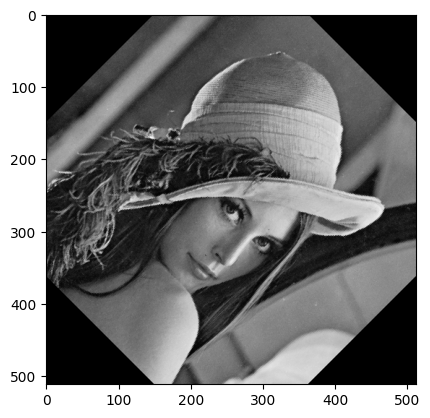

In [14]:
plt.imshow(rotation(im,45,alpha=1),cmap='gray')

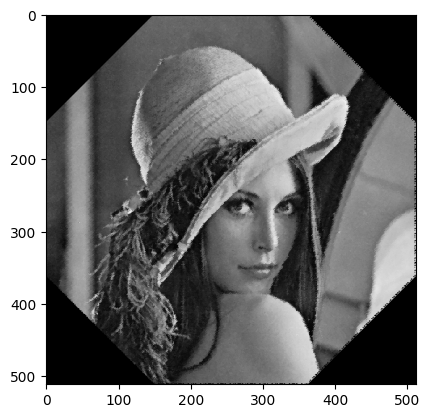

In [18]:
for i in range(8):
    im = rotation(im,45,alpha=1)
plt.imshow(im,cmap='gray')

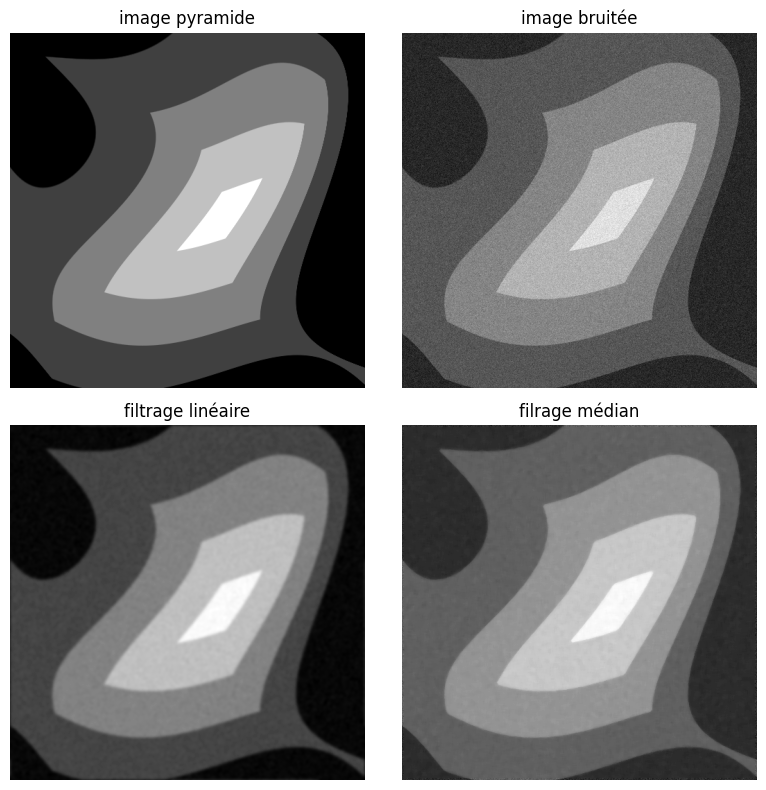

In [24]:
im=skio.imread('images/pyramide.tif')
imbr = noise(im,10)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0,0].imshow(im, cmap='gray')
axs[0,0].set_title('image pyramide')

axs[0,1].imshow(imbr, cmap='gray')
axs[0,1].set_title('image bruitée')

axs[1,0].imshow(filtre_lineaire(imbr,get_gau_ker(2)), cmap='gray')
axs[1,0].set_title('filtrage linéaire')

axs[1,1].imshow(median_filter(imbr,r=3), cmap='gray')
axs[1,1].set_title('filrage médian')

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()

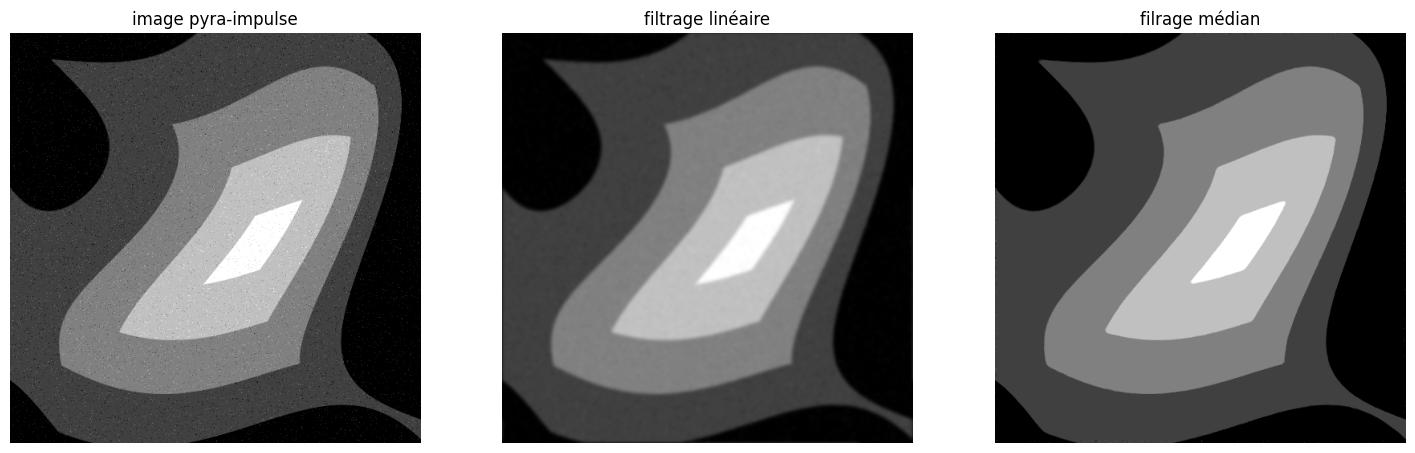

In [5]:
im=skio.imread('images/pyra-impulse.tif')

fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('image pyra-impulse')
axs[1].imshow(filtre_lineaire(im,get_gau_ker(2)), cmap='gray')
axs[1].set_title('filtrage linéaire')
axs[2].imshow(median_filter(im,r=3), cmap='gray')
axs[2].set_title('filrage médian')

for ax in axs:
    ax.axis('off')

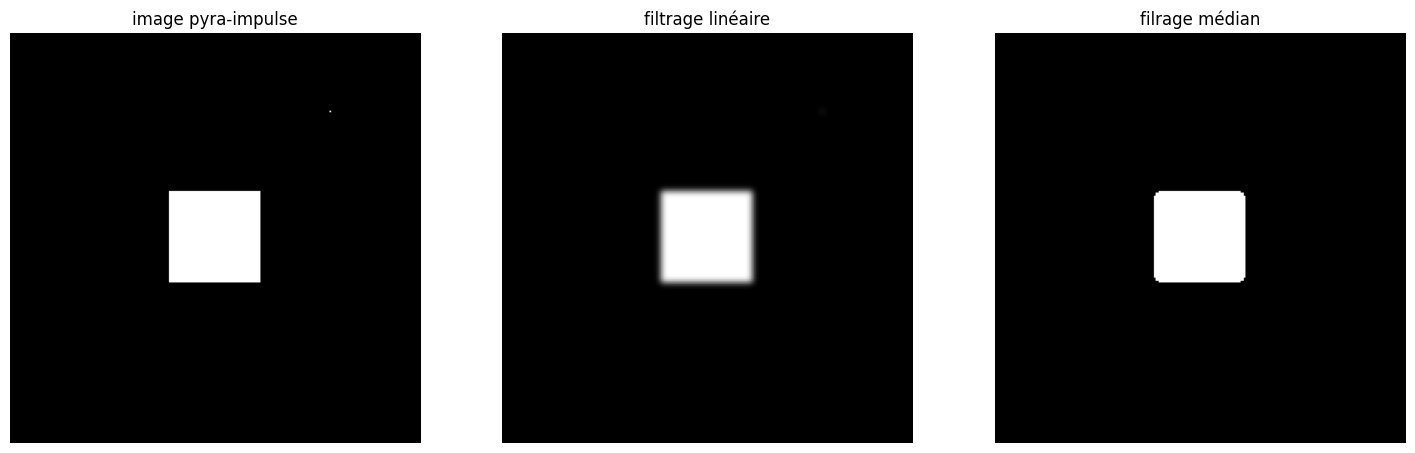

In [7]:
im=skio.imread('images/carre_orig.tif')

fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('image pyra-impulse')
axs[1].imshow(filtre_lineaire(im,get_gau_ker(2)), cmap='gray')
axs[1].set_title('filtrage linéaire')
axs[2].imshow(median_filter(im,r=3), cmap='gray')
axs[2].set_title('filrage médian')

for ax in axs:
    ax.axis('off')

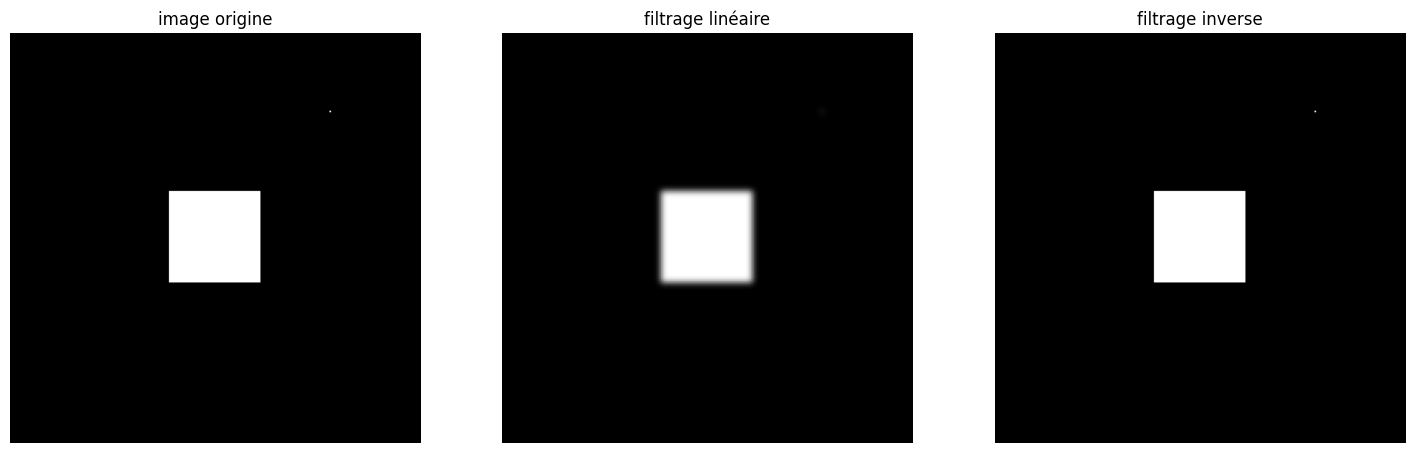

In [11]:
im=skio.imread('images/carre_orig.tif')
#filtrage linéaire
imf = filtre_lineaire(im,get_gau_ker(2))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('image origine')
axs[1].imshow(imf, cmap='gray')
axs[1].set_title('filtrage linéaire')
#filtrage inverse
axs[2].imshow(filtre_inverse(imf,get_gau_ker(2)), cmap='gray')
axs[2].set_title('filtrage inverse')

for ax in axs:
    ax.axis('off')



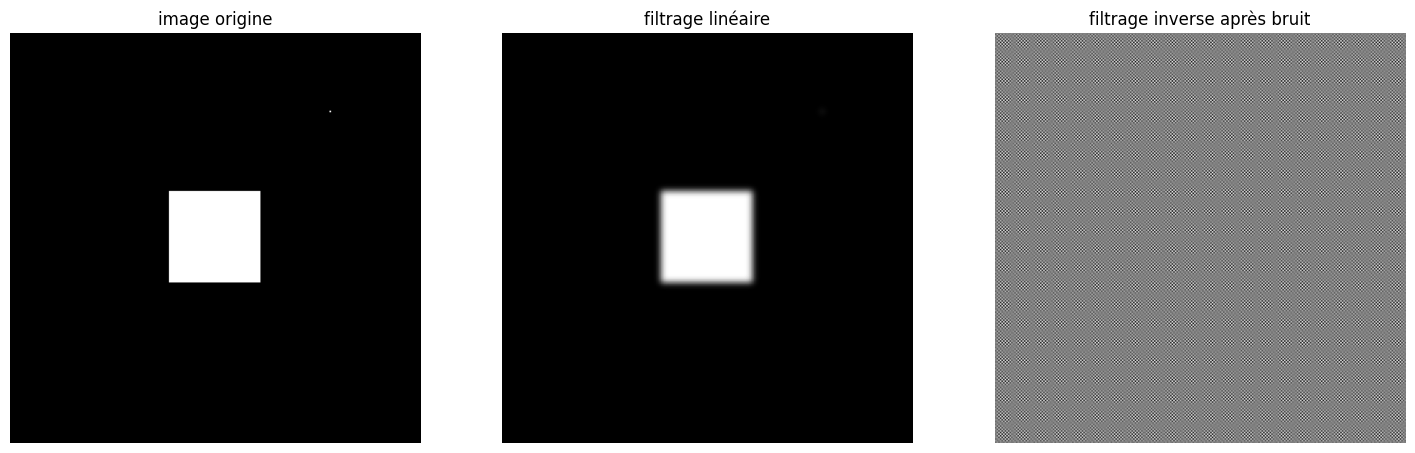

In [15]:
im=skio.imread('images/carre_orig.tif')

#filtrage linéaire
imf = filtre_lineaire(im,get_gau_ker(2))
imbr=noise(imf,10)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('image origine')
axs[1].imshow(imf, cmap='gray')
axs[1].set_title('filtrage linéaire')
#filtrage inverse
axs[2].imshow(filtre_inverse(imbr,get_gau_ker(2)), cmap='gray')
axs[2].set_title('filtrage inverse après bruit')

for ax in axs:
    ax.axis('off')

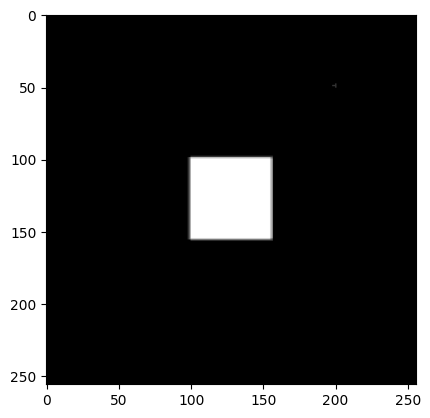

In [33]:
im=skio.imread('images/carre_flou.tif')
plt.imshow(im, cmap='gray')


In [ ]:
#Trouver le noyau de flou
print(len(im),len(im[0]))
im2=im[128:]
for i in range(len(im2)):
    im2[i]=im2[i][128:]
print(len(im2),len(im2[0]))